# Regularization
Generally, we want to choose $θ$ to achieve low empirical risk $\mathcal{L}(θ)$, but we also do not want to overfit the model $g(\theta)$. A regularizer $\mathcal{R}: \mathbb{R}^{p} \rightarrow \mathbb{R}$ is a function that measures the insensitivity of $g(\theta)$.

In regularized empirical risk minimization (RERM) we choose to minimize $\mathcal{L}(θ) + \lambda\mathcal{R}(\theta) $ where $\lambda > 0$ is the regularization hyperparameter controlling the amount of regularization. We try to find the value $\lambda$ so the test error is minimal.

Generally, we can express  regularization as:

$\mathcal{L}(θ) + \lambda\mathcal{R}(\theta) $ where $\lambda > 0$.

If we use square (quadratic) loss $l(\hat{y}, y) = (\hat{y}_i - y_i)^2$ and regularization, choosing $\theta$ to minimize:

*   $\mathcal{L}(θ) + λ\lVert θ \rVert^2_2$ is called ridge regression
*   $\mathcal{L}(θ) + λ\lVert θ \rVert_1$ is called lasso regression




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

Several parts of this lab were kindly borrowed from the [SDS 293 Machine Learning course. lab 10](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html).

In this dataset, we will predict players' salary based on the game statistics of the players. Before proceeding, let's first load the data and ensure that the missing values have been removed from the data.

In [4]:
df = pd.read_csv('https://gist.githubusercontent.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad/raw/d9bcf657f97201394a59fffd801c44347eb7e28d/Hitters.csv',
                 index_col=0).dropna()

df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Next, we can one-hot encode 'League', 'Division', and 'NewLeague' columns using `pandas`.

In [3]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])


# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    bool   
 17  Division_W   263 non-null    bool   
 18  NewLeague_N  263 non-null    bool 

Here, we extract the response into `y`. If you want, you can check its histogram.

In [5]:
y = df.Salary

To be able to proces the data, we will first scale it by dividing by the standard deviation.

In [6]:
scaler = StandardScaler(with_mean=False)
X_s = scaler.fit_transform(X)

## Ridge regression
Ridge regression uses squared $L_2$ norm to regularize the coefficients, and that way decreases the variance of the model.

The `Ridge()` constructor has an `alpha` parameter ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [7]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

 With each alpha value is associated a vector of ridge regression coefficients, which we'll together store in a matrix `coefs`. In this case, it is a $19 \times 100$ matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [8]:
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_s, y)
    coefs.append(ridge.coef_)

np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of $L_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot it and find out how the value of coefficients changes relatively to `alpha` parameter:

Text(0, 0.5, 'weights')

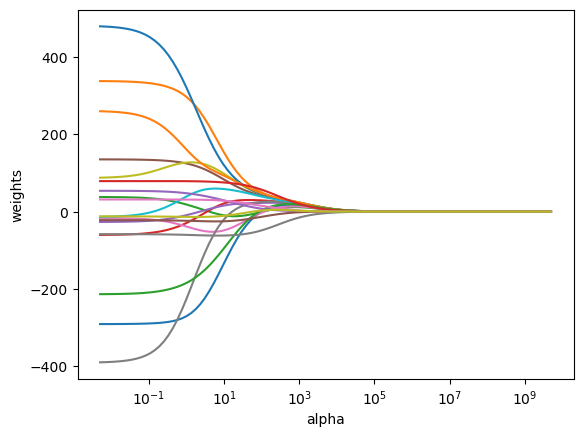

In [9]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso.

In [10]:
# Splits data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X_s, y, test_size=0.6, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [11]:
ridge_a4 = Ridge(alpha = 4)
ridge_a4.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred_a4 = ridge_a4.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge_a4.coef_, index = X.columns)) # Print coefficients
print(f"Intercept:{ridge_a4.intercept_}")
print(f"MSE estimate using ridge with alpha=4: {mean_squared_error(y_test, pred_a4):.3f}")

AtBat         -140.720454
Hits           226.180417
HmRun          -80.728029
Runs           -16.950524
RBI             77.874610
Walks           87.650595
Years           50.001210
CAtBat         -72.018920
CHits           39.000268
CHmRun         108.306284
CRuns           39.361303
CRBI            71.424792
CWalks         -31.401664
PutOuts        133.103256
Assists        -18.220708
Errors          -2.923384
League_N        42.281776
Division_W     -72.418275
NewLeague_N    -23.411253
dtype: float64
Intercept:-80.52275523786079
MSE estimate using ridge with alpha=4: 136472.099


The test MSE when `alpha=4` is $136616$. Now let's see what happens if we use a huge value of alpha, say $10^{10}$.

----------------
**Your task is to**:

----------------
Create a ridge regression model with a huge value of `alpha`, e.g. $10^{10}$. Fit the regression model to the data and use the model to predict the test data.

In [15]:
ridge_a10 = Ridge(alpha=10**10)# create a rigde regression model with alpha = 10^10
# Fit a ridge regression on the training data
ridge_a10.fit(X_train, y_train)
pred_a10 = ridge_a10.predict(X_test)# Use this model to predict the test data
print(pd.Series(ridge_a10.coef_, index = X.columns))
print(f"MSE of estimate using ridge with alpha=10^10: {mean_squared_error(y_test, pred_a10):.3f}")

AtBat          2.615466e-06
Hits           3.010265e-06
HmRun          2.128582e-06
Runs           2.785398e-06
RBI            3.274743e-06
Walks          2.882044e-06
Years          2.379115e-06
CAtBat         3.019419e-06
CHits          3.201410e-06
CHmRun         3.499569e-06
CRuns          3.199229e-06
CRBI           3.649311e-06
CWalks         2.795654e-06
PutOuts        2.996463e-06
Assists       -2.510965e-07
Errors         6.400656e-08
League_N      -2.597666e-07
Division_W    -1.060256e-06
NewLeague_N   -2.357397e-07
dtype: float64
MSE of estimate using ridge with alpha=10^10: 180039.211


Okay, so fitting a ridge regression model with `alpha=4` leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with `alpha=4` instead of
just performing least squares regression. Recall that least squares is simply ridge regression with `alpha=0`.

In [16]:
ridge_ols = Ridge(alpha=0)
ridge_ols.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge_ols.predict(X_test)            # Use this model to predict the test data
print("Coefficients:")
print(pd.Series(ridge_ols.coef_, index = X.columns)) # Print coefficients
print(f"MSE of OLS estimate using ridge with alpha=0: {mean_squared_error(y_test, pred):.3f}")

Coefficients:
AtBat         -360.296318
Hits           427.687897
HmRun          -78.169694
Runs           -85.509258
RBI            121.729842
Walks          108.437039
Years          128.646356
CAtBat        -664.438062
CHits          561.582928
CHmRun         219.877944
CRuns          144.755315
CRBI          -105.994168
CWalks         -47.993546
PutOuts        127.778004
Assists         27.677654
Errors          -9.718683
League_N        72.629503
Division_W     -67.781018
NewLeague_N    -44.741383
dtype: float64
MSE of OLS estimate using ridge with alpha=0: 136798.786


It looks like we are improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument `cv`. Notice, that the `alpha_` parameter contains the value of `alpha` chosen by cross-validation.

In [18]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
# fit the ridgecv using training data
ridgecv.fit(X_train, y_train)
print(f"Best value of alpha parameter: {ridgecv.alpha_}")

Best value of alpha parameter: 50.0


Therefore, we see that the value of alpha that results in the smallest cross-validation error is $50$. What is the test MSE associated with this value of alpha?

Below, create a regression model with `alpha` parameter equal to the value of the alpha corresponding to the lowest MSE found in crossvalidation above.

In [19]:
ridge_acv = Ridge(alpha=50)
ridge_acv.fit(X_train, y_train)
print(f"MSE of Ridge: {mean_squared_error(y_test, ridge_acv.predict(X_test))}")

MSE of Ridge: 130229.5412987928


This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [20]:
ridge_acv.fit(X, y)
pd.Series(ridge_acv.coef_, index = X.columns)

AtBat          -2.087324
Hits            7.646384
HmRun           3.356152
Runs           -2.188505
RBI            -0.565321
Walks           6.138085
Years          -2.682046
CAtBat         -0.173902
CHits           0.091696
CHmRun         -0.210409
CRuns           1.542105
CRBI            0.812549
CWalks         -0.802531
PutOuts         0.287262
Assists         0.377788
Errors         -3.075275
League_N       20.172272
Division_W    -64.507331
NewLeague_N     7.517230
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not perform variable selection!

##  The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

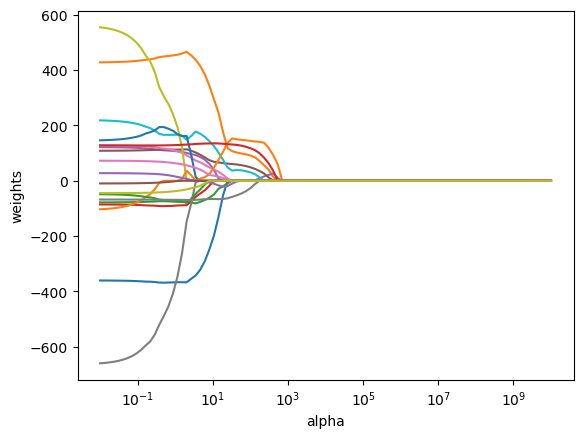

In [21]:
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
_=plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [23]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train, y_train)
print(f"Best value of alpha parameter: {lassocv.alpha_}")

Best value of alpha parameter: 37.26701616887912


After computing, we need to refit model with the best alfa, by using the `set_params` metod and then fit the data. Finally we compute the mean squarred error.

In [26]:
# set the parameter alpha to the best alpha
lasso_acv = Lasso(alpha=lassocv.alpha_, max_iter=10000)
# fit the lasso model
lasso_acv.fit(X_train, y_train)
print(f"MSE of lasso with best alpha: {mean_squared_error(y_test, lasso_acv.predict(X_test))}")

MSE of lasso with best alpha: 132092.4382911304


This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Below we plot the coefficient, notice that 13 of
the 19 coefficient estimates are exactly zero:

In [27]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lassocv.coef_, index=X.columns)

AtBat            0.000000
Hits            95.798122
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           53.404164
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          34.869508
CRuns            0.000000
CRBI           146.548079
CWalks           0.000000
PutOuts        123.346067
Assists         -0.000000
Errors          -0.000000
League_N         0.000000
Division_W     -38.371050
NewLeague_N      0.000000
dtype: float64

## Elastic net
A method combining ridge and lasso regression penalty, i.e., using $L_1$ and $L_2$ as penalty is called ridge regression. It also has the $\lambda$ parameter controlling the amount of regularization and the $\alpha$ parameter controlling the proportion of $L_1$ and $L_2$ penalty
 $\mathcal{L}(θ) + λ ( \alpha \lVert \theta \rVert_1 + (1-\alpha) \lVert \theta \rVert^2_2 )$, where $\alpha \in \langle 0, 1 \rangle$.

If $\alpha = 0.5$ both penalties are applied equally, if $\alpha=0$, ridge regression is perforemd and if $\alpha=1
$ lasso is performed.


---
**Task**

---

Look at the documentation of [elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and using cross-validation and grid search try to find the best combination of `alpha` (corresponding to $\lambda$) and `l1_ratio` (corresponding to $\alpha$) parameters for the data which we worked with above. We ignore `ConvergenceWarning` as the algorithm tends not to converge in all cases and prints warnings.

In [29]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

estimator = ElasticNet(max_iter = 10000)
param_grid = {'l1_ratio':np.linspace(0,1,20), 'alpha':alphas}
grid = GridSearchCV(estimator, param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.2...
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])})

Print the train and test MSE of the estimator corresponding to the lowest training error.

In [30]:
print(f"MSE of best estimator train data: {mean_squared_error(y_train, grid.best_estimator_.predict(X_train))}")
print(f"MSE of best estimator test data: {mean_squared_error(y_test, grid.best_estimator_.predict(X_test))}")

MSE of best estimator train data: 73613.70454944142
MSE of best estimator test data: 131127.1346935107


Finally, print the coefficients corresponding to the best model.

In [31]:
pd.Series(grid.best_estimator_.coef_, index=X.columns)

AtBat            4.485810
Hits            72.693441
HmRun          -15.504027
Runs            20.925222
RBI             38.226717
Walks           52.927396
Years           16.652774
CAtBat           9.409818
CHits           30.985703
CHmRun          50.634869
CRuns           28.432655
CRBI            47.560401
CWalks          16.175688
PutOuts        109.609309
Assists        -18.817356
Errors          -1.392512
League_N        11.644987
Division_W     -54.697145
NewLeague_N      0.000000
dtype: float64